In [41]:
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve


import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
my_region = boto3.session.Session().region_name
my_region

'eu-west-1'

In [3]:
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")
print(f"""Success - the MySageMakerInstance is in the {my_region}. 
      You will use the {xgboost_container} container for your SageMaker endpoint.
      """)

Success - the MySageMakerInstance is in the eu-west-1. 
      You will use the 685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.
      


In [4]:
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [5]:
model_data.head()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [6]:
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


In [7]:
s3 = boto3.resource('s3')
bucket_name = 'godelsagemaker'
prefix = 'sagemaker/DEMO-xgboost-dm'


pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
s3.Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [8]:
# role = '' #pass it here

# sess = sagemaker.Session()
# xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
# xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

In [9]:
X_train = train_data.drop(['y_no', 'y_yes'], axis=1)
X_test = test_data.drop(['y_no', 'y_yes'], axis=1)
y_train = train_data['y_yes']
y_test = test_data['y_yes']

In [10]:
# fit model no training data
model = XGBClassifier(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective='binary:logistic',
    num_round=100)
model.fit(X_train, y_train)

[16:32:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1660208814268/work/src/learner.cc:627: 
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.2,
              eval_metric=None, gamma=4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, num_round=100, predictor='auto',
              random_state=0, ...)

In [11]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [12]:
# evaluate predictions
#  F1 score reaches its best value at 1 and worst score at 0.
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     10936
           1       0.62      0.20      0.30      1421

    accuracy                           0.89     12357
   macro avg       0.76      0.59      0.62     12357
weighted avg       0.87      0.89      0.87     12357



In [27]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'eta' : [0.2, 0.4, 0.6, 0.8],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10]
        }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=-1, verbosity = 0)

In [28]:
folds = 5
param_comb = 6

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params,
                                   n_iter=param_comb, scoring='f1',
                                   n_jobs=-1, cv=skf.split(X_train, y_train), verbose=5,
                                   random_state=1001)

In [29]:
%%time
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.334 total time=  38.3s
[CV 2/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.347 total time=  38.4s
[CV 4/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.284 total time=  38.4s
[CV 3/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.326 total time=  38.5s
[CV 5/5] END colsample_bytree=0.8, eta=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.8;, score=0.323 total time=  38.5s
[CV 1/5] END colsample_bytree=0.6, eta=0.4, gamma=1.5, max_depth=10, min_child_weight=10, subsample=0.8;, score=0.338 total time= 1.0min
[CV 2/5] END colsample_bytree=0.6, eta=0.4, gamma=1.5, max_depth=10, min_child_weight=10, subsample=0.8;, score=0.347 total time= 1.0

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fe1126c62e0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_c...
                                           n_estimators=600, n_jobs=None,
                                           nthread=-1, num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, ...),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'eta': [0.2, 0.4, 0.6, 0.8],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5, 10],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='f1', verbose=5)

In [34]:
pd.DataFrame(random_search.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_eta,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,71.108581,8.483666,0.231215,0.044816,0.8,10,10,0.5,0.8,0.8,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 10, 'gamma': 0.5, 'eta': 0.8, 'colsample_bytree': 0.8}",0.335221,0.338496,0.330233,0.313416,0.352052,0.333883,0.012533,1
1,60.450042,0.283449,0.273484,0.005551,0.8,10,10,1.5,0.4,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 10, 'gamma': 1.5, 'eta': 0.4, 'colsample_bytree': 0.6}",0.337572,0.347144,0.317647,0.305936,0.334441,0.328548,0.014779,2
0,38.319260,0.089005,0.120011,0.002515,0.8,10,5,2,0.6,0.8,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 2, 'eta': 0.6, 'colsample_bytree': 0.8}",0.333725,0.346939,0.325960,0.284038,0.322870,0.322706,0.021045,3
3,37.273390,0.127207,0.088752,0.001891,0.8,10,4,0.5,0.8,1.0,"{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'eta': 0.8, 'colsample_bytree': 1.0}",0.333725,0.346636,0.329055,0.279290,0.319460,0.321633,0.022909,4
2,21.835391,0.215954,0.085243,0.002817,1.0,1,4,1,0.4,0.6,"{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1, 'eta': 0.4, 'colsample_bytree': 0.6}",0.326579,0.342135,0.321046,0.274791,0.310658,0.315042,0.022550,5
4,24.981268,0.099111,0.069403,0.004032,1.0,10,3,1,0.8,1.0,"{'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1, 'eta': 0.8, 'colsample_bytree': 1.0}",0.325749,0.315665,0.320574,0.270983,0.295006,0.305595,0.020209,6


In [35]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.8,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [36]:
random_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 10,
 'max_depth': 10,
 'gamma': 0.5,
 'eta': 0.8,
 'colsample_bytree': 0.8}

In [37]:
y_pred = random_search.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10936
           1       0.63      0.22      0.32      1421

    accuracy                           0.90     12357
   macro avg       0.77      0.60      0.63     12357
weighted avg       0.87      0.90      0.87     12357



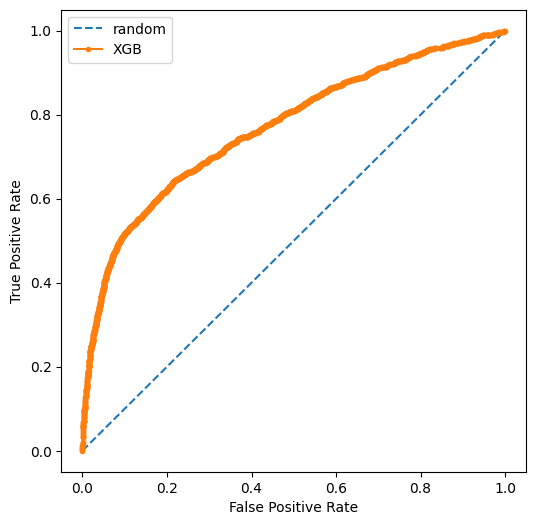

In [47]:
probas = random_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probas)
plt.figure(figsize=(6, 6)) 
plt.plot([0,1], [0,1], linestyle='--', label='random')
plt.plot(fpr, tpr, marker='.', label='XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show();